## Training and testing distance metrics

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

#Pyrepseq imports
import pyrepseq as prs
import pyrepseq.plotting as rsp
import pyrepseq.distance as rsd
import pyrepseq.stats as rss

from tcrdist.repertoire import TCRrep

#Plotting imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.style 
import matplotlib as mpl 
import seaborn as sns

from matplotlib.colors import LogNorm, Normalize

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import sys
sys.path.append( '/Users/james/Documents/UNI/Year_4/Project/tcrmetric' )
import tcrmetric_src as src

In [3]:
#Set default plotting parameters
mpl.rcParams['figure.figsize'] = [4.0, 4.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=500 

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
#Custom files
aminoacids = 'CMFILVWYAGTSNQDEHRKP'
v_genes = ["TRBV1", "TRBV2", "TRBV3-1", "TRBV3-2", "TRBV4-1", "TRBV4-2", "TRBV4-3",
           "TRBV5-1", "TRBV5-2", "TRBV5-3", "TRBV5-4", "TRBV5-5", "TRBV5-6", "TRBV5-7", "TRBV5-8",
           "TRBV6-1", "TRBV6-2", "TRBV6-3", "TRBV6-4", "TRBV6-5", "TRBV6-6", "TRBV6-7", "TRBV6-8", "TRBV6-9",
           "TRBV7-1", "TRBV7-2", "TRBV7-3", "TRBV7-4", "TRBV7-5", "TRBV7-6", "TRBV7-7", "TRBV7-8", "TRBV7-9",
           "TRBV8-1", "TRBV8-2", "TRBV9",  "TRBV10-1","TRBV10-2", "TRBV10-3", "TRBV11-1","TRBV11-2", "TRBV11-3",
           "TRBV12-1","TRBV12-2", "TRBV12-3","TRBV12-4", "TRBV12-5", "TRBV13","TRBV14", "TRBV15","TRBV16", 
           "TRBV17", "TRBV18", "TRBV19", "TRBV20-1", "TRBV21-1", "TRBV22-1", "TRBV23-1", "TRBV24-1", "TRBV25-1",
           "TRBV26", "TRBV27", "TRBV28", "TRBV29-1", "TRBV30"]

## Data import

In [5]:
mira = pd.read_csv('../data/mira/processed/peptide-detail-ci.csv')
mira = mira[mira['amino_acid'].apply(prs.isvalidcdr3)]
mira.drop_duplicates('amino_acid', inplace=True)
mira = prs.standardize_dataframe(mira
                                        , [None, None, None ,
                               "v_gene", "amino_acid", "j_gene",
                    
                                           "Amino Acids", None, None, None])

mira = mira.dropna(axis=0, subset = ["CDR3B", "TRBV", "TRBJ"] ).reset_index().drop("index", axis=1)

/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV27-01" for species HomoSapiens. Attempted fix "TRBV27-1" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV30-01" for species HomoSapiens. Attempted fix "TRBV30-1" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV12-X" for species HomoSapiens. Attempted fix "TRBV12-X" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV06-X" for species HomoSapiens. Attempted fix "TRBV6-X" did not meet the stan

/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBJ02-X" for species HomoSapiens. Attempted fix "TRBJ2-X" did not meet the standardised format requirements. Ignoring this gene name...
  warn(


## Model design

### Weighted Levenshtein distance

In [6]:
import torch
import numpy as np
import torch.nn as nn
import pyrepseq.distance as rsd
from rapidfuzz.process import cdist as rfcdist
from rapidfuzz.distance import Levenshtein

from scipy.spatial.distance import squareform

class weightedLevenshteinModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Levenshtein"
        
    def weightedLevenshtein(self,*args,**kwargs):
        
        return Levenshtein.distance(*args,**kwargs,weights=(1+np.log(4),1+np.log(4),1))
         
    def pdist(self, sequence_elements):

        distances = 0
        
        try:
            full_cdist = rfcdist(sequence_elements["CDR3A"],sequence_elements["CDR3A"],scorer=self.weightedLevenshtein)
            distances += squareform(full_cdist)
        except:
            pass

        try:
            full_cdist = rfcdist(sequence_elements["CDR3B"],sequence_elements["CDR3B"],scorer=self.weightedLevenshtein)
            distances += squareform(full_cdist)
        except:
            pass

        return torch.Tensor(distances)
    
    def cdist(self, sequence_elements_1, sequence_elements_2):
        distances = 0
        try:
            distances += rfcdist(sequence_elements_1["CDR3A"],sequence_elements_2["CDR3A"],scorer=self.weightedLevenshtein)

        except:
            pass

        try:
            distances += rfcdist(sequence_elements_1["CDR3B"],sequence_elements_2["CDR3B"],scorer=self.weightedLevenshtein)
        except:
            pass

        return torch.Tensor(distances)

### V gene embedder

In [7]:
v_gene_to_number = {gene : num for num, gene in enumerate(v_genes)}

#Bag of words model
class TRBV_Embedder(nn.Module):
    def __init__(self, name, output_size):
        super().__init__()
        self.name = name
        self.TRBV_weights = nn.Parameter(torch.normal(0, 1e-5, (len(v_gene_to_number), output_size)
                                                     , requires_grad=True, dtype=torch.double))
        
    def tokenise_TRBV(self, seqs):
        tokens = np.zeros((len(seqs),len(v_gene_to_number)))
            
        for i, seq in enumerate(seqs):
            j = v_gene_to_number[seq]
            tokens[i,j] += 1
                
        return torch.from_numpy(tokens)
    
    def forward(self, sequence_elements):
            
        #Get a vector representation for each sequence element
        vects = []
        for key, sequence_element in sequence_elements.items():    
            if key == "TRBV":
                element_token = self.tokenise_TRBV(sequence_element)
                vects.append(torch.matmul(element_token, self.TRBV_weights))
                
        #Combine the sequence element vectors
        vect = torch.cat(vects,dim=1)
                
        #Normalize the result
        return (vect.T/torch.linalg.norm(vect,dim=1)).T
        
    def pdist(self, sequence_elements):
            
        x = self(sequence_elements)
            
        return torch.pdist(x)

    def cdist(self, sequence_elements_1, sequence_elements_2):
            
        x = self(sequence_elements_1)
        y = self(sequence_elements_2)
        
        return torch.cdist(x,y)

### V gene embedder with Levenshtein distance

In [8]:
v_gene_to_number = {gene : num for num, gene in enumerate(v_genes)}

#Bag of words model
class TRBVL_Embedder(nn.Module):
    def __init__(self, name, output_size):
        super().__init__()
        self.name = name
        self.TRBV_weights = nn.Parameter(torch.normal(0, 1e-5, (len(v_gene_to_number), output_size)
                                                     , requires_grad=True, dtype=torch.double))
        
    def weightedLevenshtein(self,*args,**kwargs):
        
        return Levenshtein.distance(*args,**kwargs,weights=(1+np.log(4),1+np.log(4),1))
         
        
    def tokenise_TRBV(self, seqs):
        tokens = np.zeros((len(seqs),len(v_gene_to_number)))
            
        for i, seq in enumerate(seqs):
            j = v_gene_to_number[seq]
            tokens[i,j] += 1
                
        return torch.from_numpy(tokens)
    
    def forward(self, sequence_elements):
            
        #Get a vector representation for each sequence element
        vects = []
        for key, sequence_element in sequence_elements.items():    
            if key == "TRBV":
                element_token = self.tokenise_TRBV(sequence_element)
                vects.append(torch.matmul(element_token, self.TRBV_weights))
                
        #Combine the sequence element vectors
        vect = torch.cat(vects,dim=1)
                
        #Normalize the result
        return (vect.T/torch.linalg.norm(vect,dim=1)).T
        
    def pdist(self, sequence_elements):
            
        x = self(sequence_elements)
        
        cdr3b_pdist = torch.tensor(squareform(rfcdist(sequence_elements["CDR3B"]
                                                      ,sequence_elements["CDR3B"],scorer=self.weightedLevenshtein)))
            
        return cdr3b_pdist + torch.pdist(x)

    def cdist(self, sequence_elements_1, sequence_elements_2):
            
        x = self(sequence_elements_1)
        y = self(sequence_elements_2)
            
        cdr3b_cdist = torch.Tensor(rfcdist(sequence_elements_1["CDR3B"]
                                           ,sequence_elements_2["CDR3B"],scorer=self.weightedLevenshtein))
        
        return cdr3b_cdist + torch.cdist(x,y)

## Training and testing - Mira


In [11]:
num_epitopes = 10

In [60]:
num_epitopes = 10

metrics_levenshtein = []
metrics_wlevenshtein = []
metrics_trbv = []
metrics_trbvl = []

for i in range(20):
    training_data, training_labels, testing_data, testing_labels = src.train_test_split(mira, 500, num_epitopes, 0.25)
    
    #Levenshtein Model testing
    LevenshteinModel = src.LevenshteinModel()
    metrics_levenshtein.append(src.evaluate_model(LevenshteinModel
                                             , {"CDR3B" : testing_data["CDR3B"]}, testing_labels)["accuracy"])
    
    #Weighted Levenshtein Model testing
    wLevenshteinModel = weightedLevenshteinModel()
    metrics_wlevenshtein.append(src.evaluate_model(wLevenshteinModel
                                          , {"CDR3B" : testing_data["CDR3B"]}, testing_labels)["accuracy"])
    
    #V gene model testing
    trbvModel = TRBV_Embedder("trbv", 5)
    src.train_model(trbvModel , {"CDR3B" : training_data["CDR3B"], "TRBV" : training_data["TRBV"]}, training_labels
                     , src.physical_loss, margin = 2
                     , niters = 200, batch_size = 50
                     , lr = 1e-2, return_evaluations = False)
    
    metrics_trbv.append(src.evaluate_model(trbvModel, {"CDR3B" : testing_data["CDR3B"],
                                              "TRBV" : testing_data["TRBV"]}, testing_labels)["accuracy"])
    
    #V gene model with weighted Levenshtein distance testing
    trbvlModel = TRBVL_Embedder("trbv", 5)
    
    src.train_model(trbvlModel , {"CDR3B" : training_data["CDR3B"], "TRBV" : training_data["TRBV"]}, training_labels
                     , src.physical_loss, margin = 2
                     , niters = 200, batch_size = 50
                     , lr = 1e-2, return_evaluations = False)
    
    metrics_trbvl.append(src.evaluate_model(trbvlModel, {"CDR3B" : testing_data["CDR3B"],
                                              "TRBV" : testing_data["TRBV"]}, testing_labels)["accuracy"])
    

Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.22it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [01:24<00:00,  2.37it/s]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.88it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [01:24<00:00,  2.36it/s]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.37it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [01:23<00:00,  2.38it/s]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.26it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [01:24<00:00,  2.37it/s]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.94it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [03:12<00:00,  1.04it/s]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.69it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [18:06<00:00,  5.43s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.59it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [1:24:17<00:00, 25.29s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.74it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [40:09<00:00, 12.05s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.93it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [17:59<00:00,  5.40s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.49it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [21:10<00:00,  6.35s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.99it/s]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [10:02<00:00,  3.01s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.95it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [1:50:16<00:00, 33.08s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.72it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [1:47:23<00:00, 32.22s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [14:25<00:00,  4.33s/it]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [44:42<00:00, 13.41s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.45it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [2:15:39<00:00, 40.70s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.62it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [2:00:32<00:00, 36.16s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [28:21<00:00,  8.51s/it]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [1:41:51<00:00, 30.56s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.62it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [1:45:46<00:00, 31.73s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 63.87it/s]


Finished training
Testing trbv
-----Training trbv------


100%|███████████████████████████████████████| 200/200 [1:28:59<00:00, 26.70s/it]


Finished training
Testing trbv
Data set split into 3750 training sequences and 1250 testing sequences
Testing Levenshtein
Testing Levenshtein
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [15:30<00:00,  4.65s/it]


Finished training
Testing trbv
-----Training trbv------


100%|█████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


Finished training
Testing trbv


In [61]:
#np.savetxt('metrics_levenshtein.csv', metrics_levenshtein, delimiter=',')
#np.savetxt('metrics_wlevenshtein.csv', metrics_wlevenshtein, delimiter=',')
#np.savetxt('metrics_trbv.csv', metrics_trbv, delimiter=',')
#np.savetxt('metrics_trbvl.csv', metrics_trbvl, delimiter=',')

## Comparing performance 

In [9]:
acc_levenshtein = np.loadtxt("metrics_levenshtein.csv",
                 delimiter=",")
acc_wlevenshtein = np.loadtxt("metrics_wlevenshtein.csv",
                 delimiter=",")
acc_trbv = np.loadtxt("metrics_trbv.csv",
                 delimiter=",")
acc_trbvl = np.loadtxt("metrics_trbvl.csv",
                 delimiter=",")

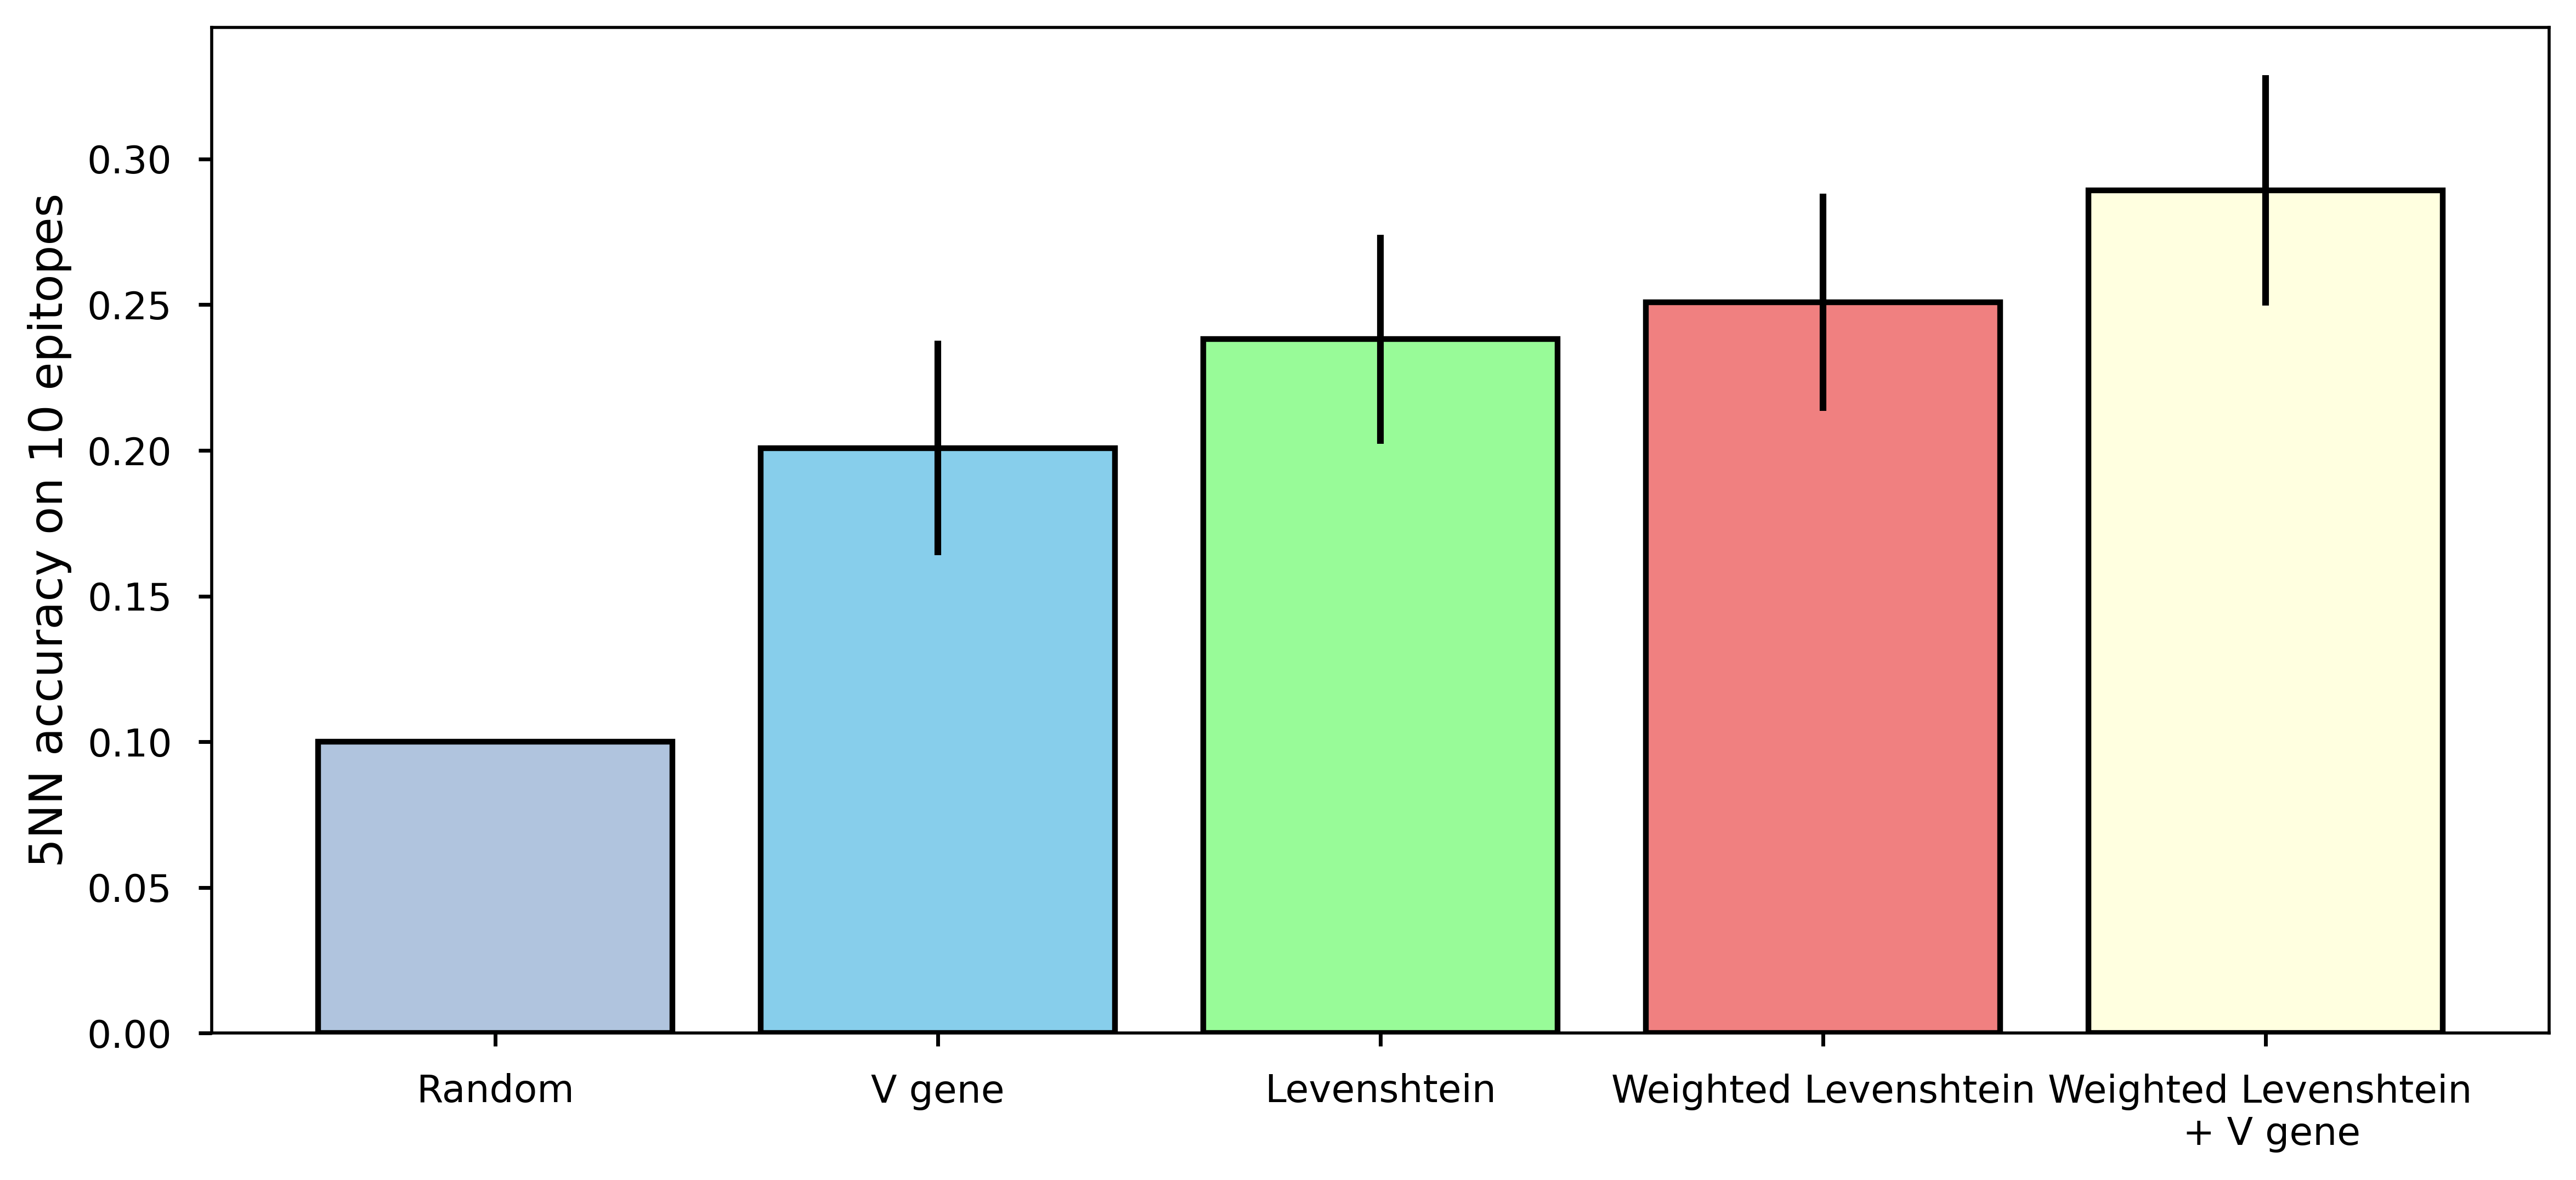

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
fig.tight_layout(pad=3.0)

bars = ("Random","V gene","Levenshtein","Weighted Levenshtein","Weighted Levenshtein \n + V gene")
ypos = np.arange(len(bars))

ax.bar(1,1/num_epitopes,color='lightsteelblue', edgecolor='black',linewidth=1.5)
ax.bar(2,np.mean(acc_trbv),yerr=np.std(acc_trbv),color='skyblue', edgecolor='black',linewidth=1.5)
ax.bar(3,np.mean(acc_levenshtein),yerr=np.std(acc_levenshtein),color='palegreen', edgecolor='black',linewidth=1.5)
ax.bar(4,np.mean(acc_wlevenshtein),yerr=np.std(acc_wlevenshtein),color='lightcoral', edgecolor='black',linewidth=1.5)
ax.bar(5,np.mean(acc_trbvl),yerr=np.std(acc_trbvl),color='lightyellow', edgecolor='black',linewidth=1.5)

ax.set_ylabel(f'5NN accuracy on {num_epitopes} epitopes')
ax.set_xticks([1,2,3,4,5],bars);